In [1]:
import pandas as pd

pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列

In [2]:
depolarizing_csv_path = "depolarizing.csv"
df = pd.read_csv(depolarizing_csv_path)
df = df[df["ARG"] < 0.15]
cols_to_avg = [col for col in df.columns[6:] if col != 'p_gate1']
df[cols_to_avg] = df[cols_to_avg].apply(pd.to_numeric, errors='coerce')

df_hard = pd.read_csv('amp_damping_probability.csv')
df_hard = df_hard.drop(columns=['pbid'])
grouped_df = df_hard.groupby(['amp'], as_index=False).agg({
    'ARG': ['mean', 'std'],
})

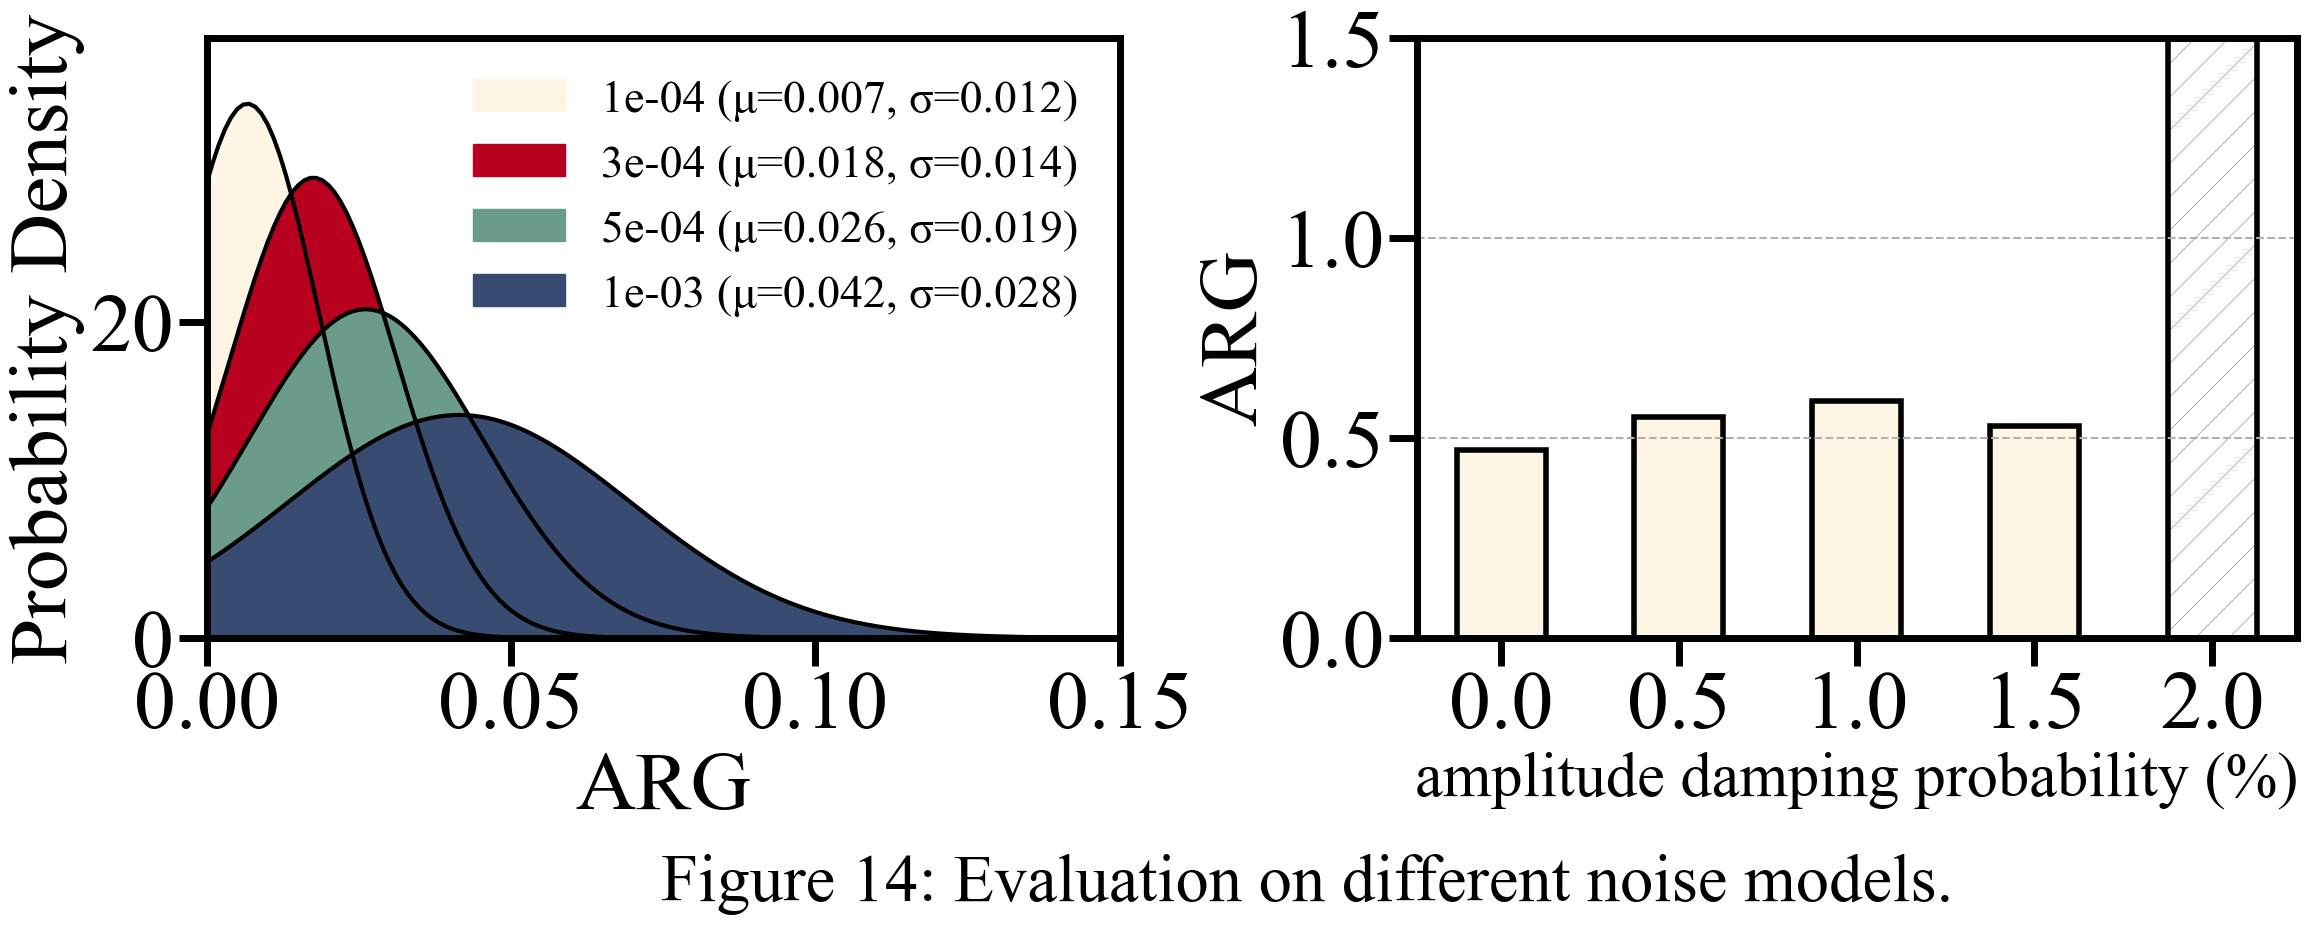

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import norm

scale = 1
mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60 * scale,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5 * scale,
    'xtick.major.size': 20 * scale,
    'xtick.major.width': 5 * scale,
    'xtick.minor.size': 10 * scale,
    'xtick.minor.width': 3 * scale,
    'ytick.major.size': 20 * scale,
    'ytick.major.width': 5 * scale,
    'ytick.minor.size': 10 * scale,
    'ytick.minor.width': 3 * scale,
    'lines.markersize': 35 * scale,
    'lines.markeredgewidth': 4 * scale,
    'markers.fillstyle': 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
    'hatch.linewidth': 0.2 * scale,
    'hatch.color': 'black',
    'lines.linewidth': 0.7 * scale,
})

fig = plt.figure(figsize=(22 * scale, 12 * scale))
ax1 = plt.axes((0, 0, 0.415, 0.5))
ax2 = plt.axes((0.55, 0, 0.4, 0.5))

bar_width = 0.15
colors = ['#FFF5E4','#B8001F', '#6A9C89','#384B70']
x = np.linspace(0, 1, 1000)
for i, category in enumerate([1e-4, 3e-4, 5e-4, 1e-3]):
    subset = df[df["p_gate1"] == category]["ARG"]
    subset = pd.to_numeric(subset, errors='coerce').dropna()
    subset = subset[np.isfinite(subset)]
    if len(subset) == 0:
        continue
    mu, sigma = norm.fit(subset)
    pdf = norm.pdf(x, mu, sigma)
    ax1.plot(x, pdf, color='black', linewidth=3, zorder=1)
    ax1.fill_between(x, pdf, color=colors[i], label=f'{category:.0e} (μ={mu:.3f}, σ={sigma:.3f})', zorder=0)


ax1.legend(loc='upper right', ncol=1, frameon=False, prop={'size': 33})
ax1.set_xlabel('ARG')
ax1.set_ylabel('Probability Density')
ax1.set_xlim(0, 0.15)
ax1.set_ylim(0, 38)

bar_width = 0.5
colors = ['#FFF5E4', '#B8001F', '#6A9C89', '#384B70']
target_amps = [0.0, 0.005, 0.01, 0.015, 0.02]
x = np.arange(len(target_amps))

for i, amp in enumerate(target_amps):
    # 找 grouped_df 里是否有对应的 amp 行
    row = grouped_df[grouped_df['amp'] == amp]
    if not row.empty:
        y_val = row[('ARG', 'mean')].values[0]
        color = colors[0]
        ax2.bar(
            x[i], y_val, bar_width,
            color=color, edgecolor="black", linewidth=4 * scale, label=f'{amp:.3f}'
        )
    else:
        ax2.bar(
            x[i], 2, bar_width,
            color='white', edgecolor="black", linewidth=4 * scale, hatch='/',
            label=f'{amp:.3f} (missing)'
        )

ax2.set_xlabel('amplitude damping probability (%)', fontsize=45)
ax2.set_ylabel('ARG')
ax2.set_xticks(x, labels=[x_label * 100 for x_label in target_amps])
ax2.set_ylim(0, 1.5)
ax2.grid(True, linestyle='--', linewidth=1.5 * scale, axis='y')


title = "Figure 14: Evaluation on different noise models"
plt.suptitle(title, y=-0.18, fontsize=48)
plt.savefig(f'{title}.svg', bbox_inches='tight')
plt.show()